In [ ]:
!pip install qrcode
import os
import pandas as pd
import qrcode

In [ ]:
input_csv_path = '/kaggle/input/qm9-smiles-props/qm9_smiles_properties.csv'  
output_dir = '/kaggle/working/smiles_qr_codes'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df = pd.read_csv(input_csv_path)

for index, row in df.iterrows():
    smiles = row['SMILES']
    molecule_id = row['Index'] 
    
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=2,
    )
    qr.add_data(smiles)
    qr.make(fit=True)
    
    img = qr.make_image(fill_color="black", back_color="white")
    img_path = os.path.join(output_dir, f'{molecule_id}.png')
    img.save(img_path)

print(f"QR codes saved in: {output_dir}")

In [ ]:
!zip -r file.zip /kaggle/working

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import time

In [2]:
train_folder = "/kaggle/input/qr-15-train/15_train/train"
val_folder = "/kaggle/input/qr-15-train/15_train/val"
test_folder = "/kaggle/input/qr-15-train/15_train/test"

csv_file = "/kaggle/input/qm9-smiles-props/qm9_smiles_properties.csv"

In [3]:
properties_df = pd.read_csv(csv_file)

properties_df.iloc[:, 1] = properties_df.iloc[:, 1].astype(str)
smiles_idx = properties_df.iloc[:, 1].values  
properties = properties_df.iloc[:, -2].values  

properties_dict = dict(zip(smiles_idx, properties))

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
def load_images_from_folder(folder):
    image_tensors = []
    property_values = []
    
    for img_name in os.listdir(folder):
        if img_name.endswith(".png"):
            img_path = os.path.join(folder, img_name)
            smiles_id = img_name.replace(".png", "")  
            image = Image.open(img_path)
            image = transform(image)
            image_tensors.append(image)
            property_values.append(properties_dict[smiles_id])
    
    return torch.stack(image_tensors), torch.tensor(property_values, dtype=torch.float32)

In [5]:
train_images, train_properties = load_images_from_folder(train_folder)
val_images, val_properties = load_images_from_folder(val_folder)
test_images, test_properties = load_images_from_folder(test_folder)

train_dataset = TensorDataset(train_images, train_properties)
val_dataset = TensorDataset(val_images, val_properties)
test_dataset = TensorDataset(test_images, test_properties)

In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
model = models.resnet18(pretrained=True)

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

consecutive_increase_counter = 0
max_allowed_increases = 4
prev_val_loss = float('inf')

train_losses = []
val_losses = []

epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, properties in train_loader:
        images, properties = images.to(device), properties.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        outputs = outputs.squeeze(-1)
        loss = criterion(outputs, properties)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss) 

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, properties in val_loader:
            images, properties = images.to(device), properties.to(device)

            outputs = model(images)
            outputs = outputs.squeeze(-1)
            loss = criterion(outputs, properties)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss > prev_val_loss:
        consecutive_increase_counter += 1
    else:
        consecutive_increase_counter = 0 

    prev_val_loss = avg_val_loss

    if consecutive_increase_counter >= max_allowed_increases:
        print(f"Early stopping triggered after {max_allowed_increases} consecutive increases in validation loss!")
        break

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s] 


Epoch [1/50], Train Loss: 43236.1730, Validation Loss: 861.7204
Epoch [2/50], Train Loss: 706.7475, Validation Loss: 583.9507
Epoch [3/50], Train Loss: 481.3122, Validation Loss: 489.2758
Epoch [4/50], Train Loss: 369.4751, Validation Loss: 398.4327
Epoch [5/50], Train Loss: 269.9417, Validation Loss: 447.5002
Epoch [6/50], Train Loss: 217.9404, Validation Loss: 369.8080
Epoch [7/50], Train Loss: 184.4530, Validation Loss: 459.2404
Epoch [8/50], Train Loss: 148.7951, Validation Loss: 342.7979
Epoch [9/50], Train Loss: 143.6917, Validation Loss: 293.0687
Epoch [10/50], Train Loss: 128.1731, Validation Loss: 304.4095
Epoch [11/50], Train Loss: 120.9356, Validation Loss: 296.9605
Epoch [12/50], Train Loss: 110.2896, Validation Loss: 311.8912
Epoch [13/50], Train Loss: 99.8166, Validation Loss: 288.6725
Epoch [14/50], Train Loss: 88.8012, Validation Loss: 303.5635
Epoch [15/50], Train Loss: 77.0933, Validation Loss: 324.6873
Epoch [16/50], Train Loss: 72.4543, Validation Loss: 374.0516
Epo

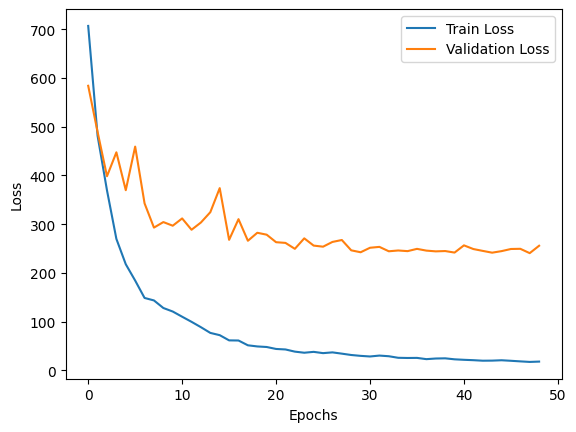

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses[1:], label='Train Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model.eval()

actual_values = []
predicted_values = []

start_time = time.time()

with torch.no_grad():
    for images, properties in test_loader:
        images, properties = images.to(device), properties.to(device)

        outputs = model(images).squeeze(-1) 
        actual_values.extend(properties.cpu().numpy())
        predicted_values.extend(outputs.cpu().numpy())

end_time = time.time()

actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)
inference_time = (end_time - start_time) / len(test_loader)

print(f"Inference Time per 1000 samples: {inference_time*1000:.4f} seconds")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-Squared (R²): {r2:.4f}")

Inference Time per 1000 samples: 10.8943 seconds
Mean Squared Error (MSE): 256.1001
Mean Absolute Error (MAE): 10.5020
R-Squared (R²): 0.8404


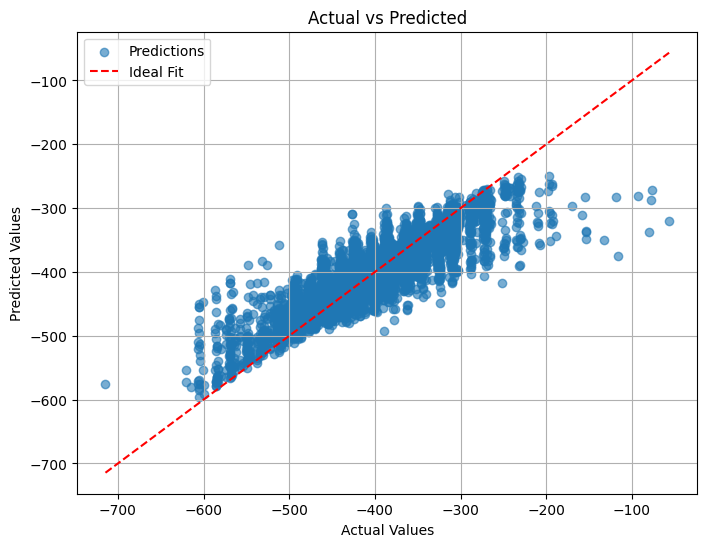

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.6, label="Predictions")
plt.plot(
    [min(actual_values), max(actual_values)],
    [min(actual_values), max(actual_values)],
    color="red",
    linestyle="--",
    label="Ideal Fit"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()